In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import seaborn as sns
from collections import Counter
from google.colab import drive
from google.colab import files
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Capstone_project/Dataset/CNN_do_zero/dataset_wbc_bom.zip'
local_path = '/content/dados_temporarios'

with zipfile.ZipFile(zip_path, 'r') as z:
     z.extractall(local_path)

caminho_dataset = '/content/dados_temporarios/dataset_crops_wbc'

# Verificar se o Python vê as pastas das células agora
if os.path.exists(caminho_dataset):
    print(f"✅ Caminho encontrado! A procurar classes em: {caminho_dataset}")
    print("Pastas encontradas:", os.listdir(caminho_dataset))
else:
    print("Erro: O caminho não está certo.")

✅ Caminho encontrado! A procurar classes em: /content/dados_temporarios/dataset_crops_wbc
Pastas encontradas: ['Monocyte', 'Eosinophil', 'Basophil', 'Neutrophil', 'Lymphocyte']


In [ ]:
#Parâmetros de treino
BATCH_SIZE = 16 # Normalmente 8 e 16 são os melhores, mais baixo leva a menos overfitting e menos risco de crash, so se aumenta se tiver boa GPU
IMG_SIZE = (128, 128)
EPOCHS = 40  # Com earlystopping pode se por muito, visto que se parar de aprender irá parar

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split=0.2
)

train_ds = datagen.flow_from_directory(
    caminho_dataset,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_ds = datagen.flow_from_directory(
    caminho_dataset,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\nClasses encontradas:", train_ds.class_indices)

Found 13339 images belonging to 5 classes.
Found 3333 images belonging to 5 classes.

Classes encontradas: {'Basophil': 0, 'Eosinophil': 1, 'Lymphocyte': 2, 'Monocyte': 3, 'Neutrophil': 4}


In [ ]:
num_classes = len(train_ds.class_indices)
model = models.Sequential()

model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,196,901 (8.38 MB)

 Trainable params: 2,196,901 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
labels_treino = train_ds.classes
contagem = Counter(labels_treino)
total = len(labels_treino)
n_classes = len(contagem)
class_weights = {}
mapa = {v: k for k, v in train_ds.class_indices.items()}

print(f"{'CLASSE':<12} | {'QTD':<6} | {'PESO AUTO':<10} | {'PESO FINAL (Ajustado)':<20}")
print("-" * 65)

for cls_id, count in contagem.items():
    peso_base = np.sqrt(total / (n_classes * count))
    peso_final = peso_base
    if cls_id == 0:
        peso_final = peso_base * 0.8
    elif cls_id == 4:
        peso_final = peso_base * 1.2

    elif cls_id == 2:
        peso_final = peso_base * 1.1 # Mantemos igual por enquanto

    class_weights[cls_id] = peso_final

    nome = mapa[cls_id]
    print(f"{nome:12s} | {count:6d} | {peso_base:8.4f}   -> {peso_final:.4f}")

CLASSE       | QTD    | PESO AUTO  | PESO FINAL (Ajustado)
-----------------------------------------------------------------
Basophil     |    241 |   3.3271   -> 2.6617
Eosinophil   |    853 |   1.7685   -> 1.7685
Lymphocyte   |   2888 |   0.9611   -> 1.0572
Monocyte     |    636 |   2.0481   -> 2.0481
Neutrophil   |   8721 |   0.5531   -> 0.6637


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definir callback e early stopping
checkpoint_path = '/content/drive/MyDrive/Capstone_project/Dataset/CNN_do_zero/modelo_do_zero4.keras'
callbacks_list = [
    # Salvar o melhor modelo
    callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),

    # Early Stopping, caso o modelo não melhore durante 15 epochs pára e usa os melhores pesos
    callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),

    # Se o erro não descer durante 3 épocas, reduz a velocidade para metade
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6596 - loss: 1.1445
Epoch 1: val_loss improved from inf to 1.79933, saving model to /content/drive/MyDrive/Capstone_project/Dataset/CNN_do_zero/modelo_do_zero4.keras
834/834 ━━━━━━━━━━━━━━━━━━━━ 117s 136ms/step - accuracy: 0.6596 - loss: 1.1443 - val_accuracy: 0.2778 - val_loss: 1.7993 - learning_rate: 5.0000e-04
Epoch 2/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8435 - loss: 0.5899
Epoch 2: val_loss did not improve from 1.79933
834/834 ━━━━━━━━━━━━━━━━━━━━ 110s 131ms/step - accuracy: 0.8435 - loss: 0.5898 - val_accuracy: 0.2970 - val_loss: 2.1453 - learning_rate: 5.0000e-04
Epoch 3/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8948 - loss: 0.3704
Epoch 3: val_loss improved from 1.79933 to 1.11045, saving model to /content/drive/MyDrive/Capstone_project/Dataset/CNN_do_zero/modelo_do_zero4.keras
834/834 ━━━━━━━━━━━━━━━━━━━━ 109s 131ms/step - accuracy: 0.8948 - loss: 0.3703 - val_accuracy: 

In [ ]:
caminho_modelo = '/content/drive/MyDrive/Capstone_project/Dataset/CNN_do_zero/modelo_do_zero4.keras'

# Verifica se o ficheiro existe antes de carregar
if os.path.exists(caminho_modelo):
    print("🔄 A carregar o modelo treinado do Drive...")
    model = load_model(caminho_modelo)
    print("✅ Modelo carregado! Podes saltar o treino.")
    model.summary()
else:
    print("⚠️ Modelo não encontrado! Vais ter de treinar primeiro.")

🔄 A carregar o modelo treinado do Drive...
✅ Modelo carregado! Podes saltar o treino.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,757,393 (52.48 MB)

 Trainable params: 4,585,797 (17.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,171,596 (34.99 MB)

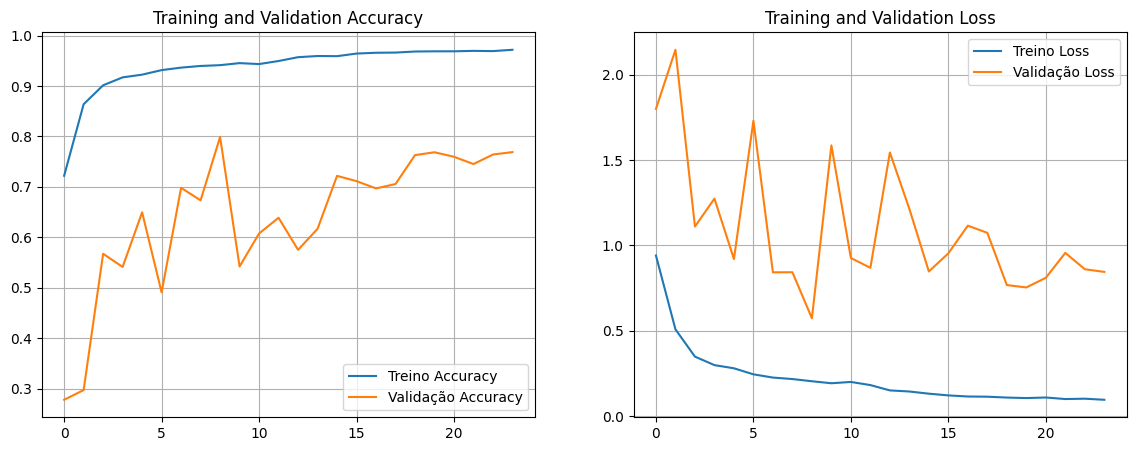

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Gráfico 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Treino Accuracy')
    plt.plot(epochs_range, val_acc, label='Validação Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Gráfico 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Treino Loss')
    plt.plot(epochs_range, val_loss, label='Validação Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.show()

# Gerar os gráficos
plot_history(history)

A ler imagens de: /content/dados_temporarios/dataset_crops_wbc
Found 3333 images belonging to 5 classes.
A gerar previsões... (pode demorar uns segundos)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 94s 886ms/step


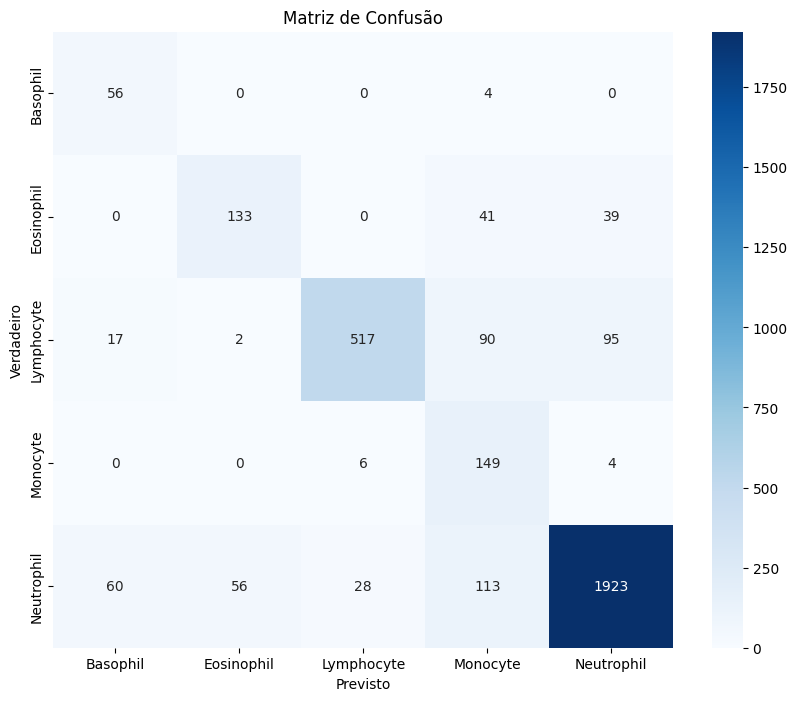


Relatório de Classificação:

              precision    recall  f1-score   support

    Basophil       0.42      0.93      0.58        60
  Eosinophil       0.70      0.62      0.66       213
  Lymphocyte       0.94      0.72      0.81       721
    Monocyte       0.38      0.94      0.54       159
  Neutrophil       0.93      0.88      0.91      2180

    accuracy                           0.83      3333
   macro avg       0.67      0.82      0.70      3333
weighted avg       0.88      0.83      0.85      3333



In [ ]:
# 1. Recriar o gerador de validação APENAS para garantir que shuffle=False
eval_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# 2. Carregar as imagens (Validar o caminho)
print(f"A ler imagens de: {caminho_dataset}")
eval_ds = eval_datagen.flow_from_directory(
    caminho_dataset,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

if eval_ds.samples > 0:
    # 3. Fazer previsões
    print("A gerar previsões... (pode demorar uns segundos)")
    Y_pred = model.predict(eval_ds)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = eval_ds.classes

    # 4. Criar a Matriz
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(eval_ds.class_indices.keys())

    # 5. Desenhar
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão')
    plt.show()

    # 6. Relatório
    print("\nRelatório de Classificação:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

else:
    print("ERRO: Continuo a encontrar 0 imagens.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/tmp/ipython-input-2821670708.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2821670708.py:46: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


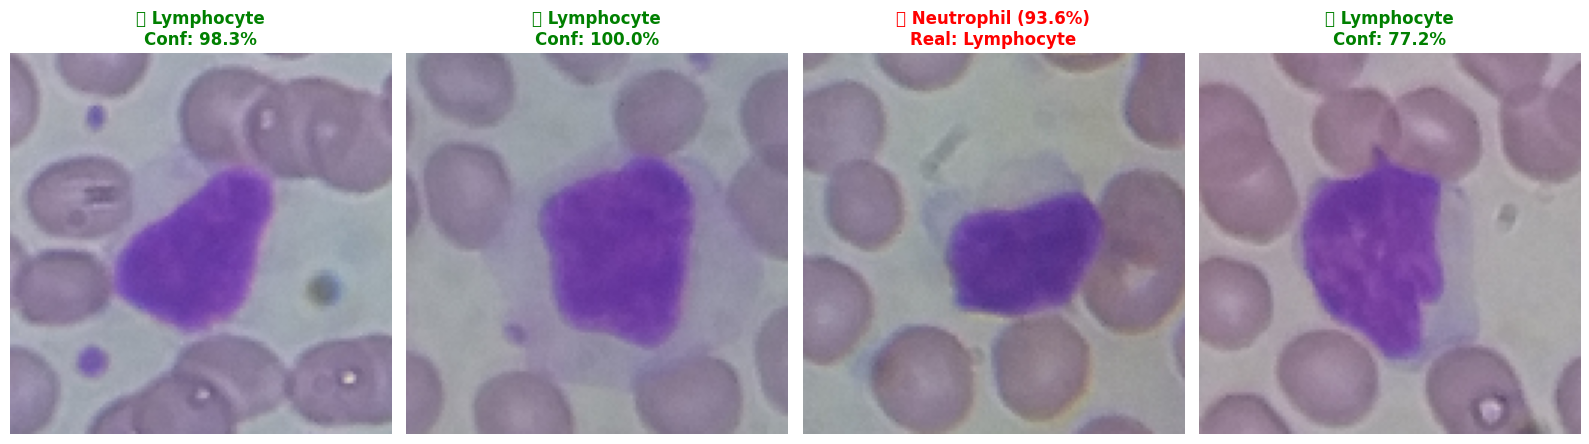

In [ ]:
num_imagens_para_mostrar = 4

# 1. Pegar num lote de imagens do conjunto de validação
imagens, labels_reais_cod = next(iter(eval_ds))

# 2. O modelo faz as previsões para essas imagens
previsoes = model.predict(imagens)

# 3. Mapear os números (0, 1, 2 e 3)
mapa_nomes = {v: k for k, v in eval_ds.class_indices.items()}

# 4. Desenhar os gráficos
plt.figure(figsize=(16, 5))

for i in range(num_imagens_para_mostrar):
    ax = plt.subplot(1, num_imagens_para_mostrar, i + 1)

    # Mostrar a imagem
    plt.imshow(imagens[i])
    plt.axis("off") # Esconde os eixos X e Y para ficar limpo

    # Cálculos
    idx_pred = np.argmax(previsoes[i])      # Índice que o modelo escolheu
    idx_real = np.argmax(labels_reais_cod[i]) # Índice verdadeiro
    nome_pred = mapa_nomes[idx_pred]        # Nome previsto
    nome_real = mapa_nomes[idx_real]        # Nome verdadeiro
    confianca = np.max(previsoes[i]) * 100  # Certeza em %

    # Texto e cor
    if idx_pred == idx_real:
        cor = 'green'
        # Texto: Previsão
        titulo = f" {nome_pred}\nConf: {confianca:.1f}%"
    else:
        cor = 'red'   # Errou
        # Texto: Previsão  -> Real: Verdade
        titulo = f" {nome_pred} ({confianca:.1f}%)\nReal: {nome_real}"

    # Colocar o título na imagem
    ax.set_title(titulo, color=cor, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# 1. Confiuração
EPOCHS_POR_TESTE = 7
IMG_SIZE = (128, 128)
NUM_CLASSES = 5

# 2. Definição de pesos
class_weights = {
    0: 2.6617,
    1: 1.7685,
    2: 1.0572,
    3: 2.0481,
    4: 0.6637
}

# 3. Pré-carregamento
print(" A extrair dados de validação para a memória RAM (para ser rápido)...")

X_val_list = []
y_val_list = []

# Dar reset ao gerador para o início
val_ds.reset()

# Calcular quantos batches existem no total
total_batches = len(val_ds)

# Iterar exatamente o número de batches para não entrar em loop infinito
for i in range(total_batches):
    images, labels = next(val_ds)
    X_val_list.append(images)
    y_val_list.append(labels)

# Juntar todos os pacotes num único array gigante
X_val = np.concatenate(X_val_list)
y_val_temp = np.concatenate(y_val_list)

# Converter labels para índices (0, 1, 2...) se estiverem em One-Hot
if len(y_val_temp.shape) > 1:
    y_val_true = np.argmax(y_val_temp, axis=1)
else:
    y_val_true = y_val_temp

print(f" Dados prontos! Imagens: {X_val.shape}, Labels: {y_val_true.shape}")


# 4. Construrir o modelo
def construir_modelo(variacao, input_shape):
    model = models.Sequential()

    # Configuração de filtros
    # Variação 'Filtros_16': Começa com 16
    if variacao == 'Filtros_16':
        filtros = [16, 32, 64, 128]
    else:
        # Modelo Final (Padrão): Começa com 32
        filtros = [32, 64, 128, 256]

    # -- Blocos Convolucionais --
    # Bloco 1 (Kernel 5x5 no início)
    model.add(layers.Conv2D(filtros[0], (5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloco 2
    model.add(layers.Conv2D(filtros[1], (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloco 3
    model.add(layers.Conv2D(filtros[2], (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Bloco 4
    model.add(layers.Conv2D(filtros[3], (3, 3), padding='same', activation='relu'))

    # Variação 'Sem_Last_Pool': Remove o último MaxPooling
    if variacao == 'Sem_Last_Pool':
        pass
    else:
        model.add(layers.MaxPooling2D((2, 2)))

    # Classificador
    model.add(layers.Flatten())

    # Variação 'Dense_128': Usa 128 neurónios
    neurorios_dense = 128 if variacao == 'Dense_128' else 256
    model.add(layers.Dense(neurorios_dense, activation='relu'))

    model.add(layers.Dropout(0.4))

    # Variação 'Sigmoid': Troca a ativação final
    ativacao_final = 'sigmoid' if variacao == 'Sigmoid' else 'softmax'
    model.add(layers.Dense(NUM_CLASSES, activation=ativacao_final))

    return model

# 5. Loop de testes
variacoes = [
    'Modelo_Final',    # O teu modelo base
    'Sigmoid',         # Testa ativação antiga
    'Sem_Last_Pool',   # Testa manter resolução
    'Filtros_16',      # Testa rede mais leve
    'Dense_128'        # Testa classificador mais leve
]

resultados = []

print(f"\n A iniciar bateria de testes ({len(variacoes)} modelos) com CLASS WEIGHTS...")

for nome_teste in variacoes:
    print(f"\n--- A treinar: {nome_teste} ---")

    # Limpar sessão anterior para libertar memória
    tf.keras.backend.clear_session()

    # 1. Construir
    model = construir_modelo(nome_teste, (128, 128, 3))

    # 2. Compilar
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 3. Treinar
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_POR_TESTE,
        class_weight=class_weights,
        verbose=1
    )

    # 4. Avaliar
    print("A calcular métricas...")
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calcular métricas
    f1 = f1_score(y_val_true, y_pred, average='macro')
    acc_final = history.history['val_accuracy'][-1]
    loss_final = history.history['val_loss'][-1]

    # 5. Guardar
    resultados.append({
        'Variação': nome_teste,
        'Val Loss': round(loss_final, 4),
        'Val Accuracy': round(acc_final, 4),
        'F1-Score (Macro)': round(f1, 4)
    })

# 6. Tabela final
df_resultados = pd.DataFrame(resultados)

# Estilização para destacar o melhor
tabela_estilizada = df_resultados.style.highlight_max(axis=0, subset=['Val Accuracy', 'F1-Score (Macro)'], color='lightgreen')\
                                       .highlight_min(axis=0, subset=['Val Loss'], color='lightgreen')

print("\n Tabela Comparativa Final:")
display(tabela_estilizada)

 A extrair dados de validação para a memória RAM (para ser rápido)...
 Dados prontos! Imagens: (3333, 128, 128, 3), Labels: (3333,)

 A iniciar bateria de testes (5 modelos) com CLASS WEIGHTS...

--- A treinar: Modelo_Final ---
Epoch 1/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 126s 146ms/step - accuracy: 0.6404 - loss: 1.2154 - val_accuracy: 0.3129 - val_loss: 1.6144
Epoch 2/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 114s 136ms/step - accuracy: 0.7998 - loss: 0.7753 - val_accuracy: 0.4416 - val_loss: 1.6868
Epoch 3/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.8486 - loss: 0.6177 - val_accuracy: 0.4902 - val_loss: 1.2439
Epoch 4/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - accuracy: 0.8601 - loss: 0.5317 - val_accuracy: 0.4962 - val_loss: 1.6062
Epoch 5/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.8785 - loss: 0.4511 - val_accuracy: 0.5068 - val_loss: 1.4643
Epoch 6/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.8880 - loss: 0.4162 - val_accuracy: 0.4125 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 119s 138ms/step - accuracy: 0.6489 - loss: 1.2571 - val_accuracy: 0.6541 - val_loss: 1.0519
Epoch 2/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 114s 136ms/step - accuracy: 0.6589 - loss: 1.2496 - val_accuracy: 0.6541 - val_loss: 1.0495
Epoch 3/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.6562 - loss: 1.2348 - val_accuracy: 0.6541 - val_loss: 1.0737
Epoch 4/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 110s 132ms/step - accuracy: 0.6501 - loss: 1.2826 - val_accuracy: 0.6541 - val_loss: 1.1166
Epoch 5/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.6555 - loss: 1.2370 - val_accuracy: 0.6538 - val_loss: 1.0955
Epoch 6/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.6465 - loss: 1.2601 - val_accuracy: 0.6541 - val_loss: 1.0748
Epoch 7/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.6585 - loss: 1.2534 - val_accuracy: 0.6541 - val_loss: 1.1006
A calcular métricas...

--- A treinar: Sem_Last_Pool ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 120s 138ms/step - accuracy: 0.6699 - loss: 1.1959 - val_accuracy: 0.3441 - val_loss: 1.6787
Epoch 2/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 117s 140ms/step - accuracy: 0.8656 - loss: 0.5227 - val_accuracy: 0.2724 - val_loss: 2.5662
Epoch 3/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 120s 144ms/step - accuracy: 0.8993 - loss: 0.3896 - val_accuracy: 0.2841 - val_loss: 2.6313
Epoch 4/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 113s 135ms/step - accuracy: 0.9121 - loss: 0.3187 - val_accuracy: 0.4479 - val_loss: 1.3905
Epoch 5/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.9195 - loss: 0.2909 - val_accuracy: 0.4956 - val_loss: 1.2881
Epoch 6/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 121s 146ms/step - accuracy: 0.9217 - loss: 0.2888 - val_accuracy: 0.4230 - val_loss: 1.5120
Epoch 7/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.9241 - loss: 0.2689 - val_accuracy: 0.4413 - val_loss: 1.9429
A calcular métricas...

--- A treinar: Filtros_16 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 119s 136ms/step - accuracy: 0.6630 - loss: 1.0983 - val_accuracy: 0.4389 - val_loss: 1.6420
Epoch 2/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 136s 163ms/step - accuracy: 0.8362 - loss: 0.6079 - val_accuracy: 0.3867 - val_loss: 1.9010
Epoch 3/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 127s 152ms/step - accuracy: 0.8785 - loss: 0.4234 - val_accuracy: 0.6283 - val_loss: 1.1190
Epoch 4/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 109s 130ms/step - accuracy: 0.8984 - loss: 0.3549 - val_accuracy: 0.5953 - val_loss: 1.1867
Epoch 5/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 110s 132ms/step - accuracy: 0.9132 - loss: 0.3080 - val_accuracy: 0.6847 - val_loss: 0.9051
Epoch 6/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 108s 130ms/step - accuracy: 0.9164 - loss: 0.3025 - val_accuracy: 0.5632 - val_loss: 1.6405
Epoch 7/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 109s 130ms/step - accuracy: 0.9209 - loss: 0.2815 - val_accuracy: 0.7792 - val_loss: 0.7564
A calcular métricas...

--- A treinar: Dense_128 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 120s 139ms/step - accuracy: 0.6436 - loss: 1.2648 - val_accuracy: 0.6541 - val_loss: 1.0497
Epoch 2/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.6547 - loss: 1.2529 - val_accuracy: 0.6541 - val_loss: 1.1280
Epoch 3/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - accuracy: 0.6514 - loss: 1.2629 - val_accuracy: 0.6541 - val_loss: 1.1222
Epoch 4/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 110s 132ms/step - accuracy: 0.6580 - loss: 1.2348 - val_accuracy: 0.6541 - val_loss: 1.0960
Epoch 5/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.6566 - loss: 1.2328 - val_accuracy: 0.6541 - val_loss: 1.1048
Epoch 6/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 110s 132ms/step - accuracy: 0.6597 - loss: 1.2315 - val_accuracy: 0.6541 - val_loss: 1.0882
Epoch 7/7
834/834 ━━━━━━━━━━━━━━━━━━━━ 111s 133ms/step - accuracy: 0.6547 - loss: 1.2406 - val_accuracy: 0.6541 - val_loss: 1.0935
A calcular métricas...

 Tabela Comparativa Final:


,Variação,Val Loss,Val Accuracy,F1-Score (Macro)
0,Modelo_Final,1.904200,0.414900,0.385400
1,Sigmoid,1.100600,0.654100,0.158200
2,Sem_Last_Pool,1.942900,0.441300,0.459700
3,Filtros_16,0.756400,0.779200,0.623900
4,Dense_128,1.093500,0.654100,0.158200


In [ ]:
from sklearn.metrics import f1_score, recall_score
from collections import Counter

# 1. Configuração
EPOCHS_TESTE = 5
IMG_SIZE = (128, 128)

# 2. Extração dos dados
print("A preparar dados (Isto evita loops infinitos)...")

def extrair_dados_gerador(dataset):
    """Extrai imagens e labels de um ImageDataGenerator de forma segura"""
    X_list = []
    y_list = []

    # Resetar para garantir que começa do zero
    dataset.reset()

    # Iterar apenas o número exato de batches
    total_batches = len(dataset)
    print(f" -> A processar {total_batches} batches...")

    for i in range(total_batches):
        images, labels = next(dataset)
        X_list.append(images)
        y_list.append(labels)

    X_arr = np.concatenate(X_list)
    y_arr = np.concatenate(y_list)

    # Converter one-hot para indices se necessário
    if len(y_arr.shape) > 1:
        y_indices = np.argmax(y_arr, axis=1)
    else:
        y_indices = y_arr

    return X_arr, y_indices

# Extrair Validação (Para calcular F1 e Recall rápido)
print("1. A extrair validação...")
X_val, y_val_true = extrair_dados_gerador(val_ds)

# Extrair Treino para contar classes e calcular pesos
print("2. A contar classes de treino para calcular pesos automáticos...")
labels_treino = []
train_ds.reset()
for i in range(len(train_ds)):
    _, batch_labels = next(train_ds)
    if len(batch_labels.shape) > 1:
        labels_treino.extend(np.argmax(batch_labels, axis=1))
    else:
        labels_treino.extend(batch_labels)

# 3. Pesos
contagem = Counter(labels_treino)
total_amostras = len(labels_treino)
n_classes = 5

print(f"Distribuição encontrada: {dict(contagem)}")

# Pesos Matemáticos
pesos_linear = {}
pesos_sqrt = {}
for cls_id, count in contagem.items():
    # Linear: Inverso da frequência
    score = total_amostras / (n_classes * count)
    pesos_linear[cls_id] = score
    # Sqrt: Suaviza a diferença
    pesos_sqrt[cls_id] = np.sqrt(score)

# Pesos Manuais
pesos_custom = {
    0: 2.6617,
    1: 1.7685,
    2: 1.0572,
    3: 2.0481,
    4: 0.6637
}

cenarios = [
    ("Sem Pesos", None),
    ("Linear", pesos_linear),
    ("Raiz Quadrada", pesos_sqrt),
    ("Personalizado (Final)", pesos_custom)
]

# 4. Modelo final (já criado)
def construir_modelo_final():
    model = models.Sequential()
    # Bloco 1 (Kernel 5x5)
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.BatchNormalization()) # Assumindo que o final tem BN
    model.add(layers.MaxPooling2D((2, 2)))
    # Bloco 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Bloco 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # Bloco 4 (Sem MaxPool no fim)
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    # Head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    return model

# 5. Loop para comparar pesos
resultados = []
print(f"\n A iniciar comparação de pesos...")

for nome, peso_dict in cenarios:
    print(f"\n A testar: {nome}")

    tf.keras.backend.clear_session()

    model = construir_modelo_final()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Treinar
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_TESTE,
        class_weight=peso_dict,
        verbose=1
    )

    # Avaliar (Usando X_val pré-carregado - Rápido)
    y_pred_probs = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    f1 = f1_score(y_val_true, y_pred, average='macro')
    recall = recall_score(y_val_true, y_pred, average='macro')

    resultados.append({
        'Estratégia': nome,
        'Val Accuracy': round(history.history['val_accuracy'][-1], 4),
        'F1-Score (Macro)': round(f1, 4),
        'Recall (Macro)': round(recall, 4)
    })

# 6. Criar a tabela
df = pd.DataFrame(resultados)
display(df.style.highlight_max(axis=0, subset=['F1-Score (Macro)', 'Recall (Macro)'], color='lightgreen'))

A preparar dados (Isto evita loops infinitos)...
1. A extrair validação...
 -> A processar 209 batches...
2. A contar classes de treino para calcular pesos automáticos...
Distribuição encontrada: {np.int64(4): 8721, np.int64(2): 2888, np.int64(3): 636, np.int64(1): 853, np.int64(0): 241}

 A iniciar comparação de pesos...

 A testar: Sem Pesos


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 127s 143ms/step - accuracy: 0.6180 - loss: 1.1487 - val_accuracy: 0.5758 - val_loss: 2.9790
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 114s 136ms/step - accuracy: 0.8422 - loss: 0.4874 - val_accuracy: 0.0363 - val_loss: 15.4890
Epoch 3/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 134s 161ms/step - accuracy: 0.8625 - loss: 0.3988 - val_accuracy: 0.4077 - val_loss: 2.7915
Epoch 4/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 140s 167ms/step - accuracy: 0.9003 - loss: 0.2987 - val_accuracy: 0.6241 - val_loss: 1.5770
Epoch 5/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 113s 136ms/step - accuracy: 0.9063 - loss: 0.2764 - val_accuracy: 0.4011 - val_loss: 1.3368

 A testar: Linear


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 126s 143ms/step - accuracy: 0.2865 - loss: 1.7247 - val_accuracy: 0.4140 - val_loss: 1.4891
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 134s 161ms/step - accuracy: 0.5647 - loss: 1.2135 - val_accuracy: 0.0876 - val_loss: 36.2671
Epoch 3/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 158s 189ms/step - accuracy: 0.6823 - loss: 0.8808 - val_accuracy: 0.2667 - val_loss: 4.7006
Epoch 4/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 119s 142ms/step - accuracy: 0.8051 - loss: 0.5884 - val_accuracy: 0.2775 - val_loss: 15.4118
Epoch 5/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 115s 137ms/step - accuracy: 0.8232 - loss: 0.5557 - val_accuracy: 0.2127 - val_loss: 10.9964

 A testar: Raiz Quadrada


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 126s 143ms/step - accuracy: 0.5675 - loss: 1.1269 - val_accuracy: 0.0708 - val_loss: 1657.6436
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 114s 137ms/step - accuracy: 0.8385 - loss: 0.5250 - val_accuracy: 0.1905 - val_loss: 5.5122
Epoch 3/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 115s 138ms/step - accuracy: 0.8610 - loss: 0.4370 - val_accuracy: 0.0210 - val_loss: 21.5319
Epoch 4/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.7789 - loss: 0.6567 - val_accuracy: 0.1482 - val_loss: 6.7812
Epoch 5/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 113s 135ms/step - accuracy: 0.8346 - loss: 0.5294 - val_accuracy: 0.3828 - val_loss: 2.8014

 A testar: Personalizado (Final)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 124s 141ms/step - accuracy: 0.5021 - loss: 1.5177 - val_accuracy: 0.3798 - val_loss: 2.7993
Epoch 2/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 113s 135ms/step - accuracy: 0.8400 - loss: 0.5639 - val_accuracy: 0.1482 - val_loss: 7.0414
Epoch 3/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 115s 137ms/step - accuracy: 0.8891 - loss: 0.4129 - val_accuracy: 0.6196 - val_loss: 1.4902
Epoch 4/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 112s 134ms/step - accuracy: 0.8975 - loss: 0.3617 - val_accuracy: 0.5695 - val_loss: 1.1080
Epoch 5/5
834/834 ━━━━━━━━━━━━━━━━━━━━ 113s 136ms/step - accuracy: 0.9228 - loss: 0.2797 - val_accuracy: 0.4596 - val_loss: 1.8058


,Estratégia,Val Accuracy,F1-Score (Macro),Recall (Macro)
0,Sem Pesos,0.401100,0.376700,0.575600
1,Linear,0.212700,0.330600,0.465300
2,Raiz Quadrada,0.382800,0.296000,0.425100
3,Personalizado (Final),0.459600,0.371600,0.507000
